# Endogenous model shifts

In this notebook we will use toy data to see how endogenous domain shifts and the resulting model shifts can have implications on the validity and cost of algorithmic recourse.

In [2]:
using Pkg
Pkg.activate("../")


      Status `~/OneDrive - Delft University of Technology/git/recourse/Project.toml`
  [336ed68f] CSV v0.9.11
  [a93c6f00] DataFrames v1.3.1
  [31c24e10] Distributions v0.25.14
  [5789e2e9] FileIO v1.11.2
  [587475ba] Flux v0.12.1
  [916415d5] Images v0.24.1
  [6f49c342] RCall v0.13.12
  [fce5fe82] Turing v0.19.2


  Activating project at `~/OneDrive - Delft University of Technology/git/recourse`


In [3]:
using CSV;
using DataFrames;
using LinearAlgebra;
using Distributions;
using Images, FileIO;
using RCall;
@rlibrary ggplot2
@rlibrary ggimage
@rlibrary emojifont
@rlibrary viridis
@rlibrary magick

In [4]:
include("../julia/utils.jl");
include("../julia/bayes_logreg.jl");
include("../julia/optimization.jl");

## Single-period

### Training the classifier

We start by training a simple linear classifier: Bayesian Logisitic Regression.

In [5]:
df = CSV.read("../data/cats_dogs_large.csv", DataFrame);
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);
model = bayes_logreg(X,y);
w = model.μ;

In [6]:
step = 1;
expand = 20;
W = expandgrid((minimum(df.x1)-expand):step:(maximum(df.x1)+expand),(minimum(df.x2)-expand):step:(maximum(df.x2)+expand));
N_grid = size(W)[1];

In [7]:
y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
estimates = DataFrame(hcat(y_probit,W), :auto);
features = copy(df);
transform!(features, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

The plot below shows how our classifier separate training samples of cats and dogs (toy data). The contour shows the poster predictive distribution.

In [8]:
ggplot() + 
    geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(intercept=1-w[1], slope=-w[2]/w[3]) +
    geom_image(data=features, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    theme_bw() # |>
    # p -> ggsave("www/predictive.png", plot = p, width=5, height=5)

RObject{VecSxp}


### Generating recourse

Now we will generate and implement algorithmic recourse for a subset of cats.

In [9]:
include("../julia/gradients.jl");
include("../julia/generate_recourse.jl");

In [10]:
generators = (wachter = generate_recourse_wachter, schut = generate_recourse_schut);
generator_args = (wachter=(λ=0.01,), schut=(T=100,));
df_counterfactual = [copy(df) for i in 1:length(generators)];
for j in 1:length(generators)
    insertcols!(df_counterfactual[j], :type => String(keys(generators)[j]))
end

In [11]:
proportion = 0.2
using StatsBase
cats = findall(df.y.==0);
unhappy_cats = StatsBase.sample(cats,Int(round(proportion * length(cats))),replace=false);
X_f = [[df.x1[i], df.x2[i]] for i in unhappy_cats];

In [12]:
counterfactuals = DataFrame();
for i in unhappy_cats
    x_f = [df.x1[i], df.x2[i]]
    for j in 1:length(generators)
        recourse_name = keys(generators)[j]
        recourse = generators[j](x_f,gradient,model,1;generator_args[j]...)
        y_hat = predict(model, reshape(vcat(1,recourse.x_cf),(1,length(recourse.x_cf)+1)))[1]
        # Update large data frame:
        df_counterfactual[j].y[i] = y_hat
        df_counterfactual[j].x1[i] = recourse.x_cf[1]
        df_counterfactual[j].x2[i] = recourse.x_cf[2]
        # Append small data frame:
        cf = DataFrame(reshape(recourse.x_cf,(1,length(recourse.x_cf))),:auto)
        insertcols!(cf, :type => String(recourse_name))
        insertcols!(cf, :emoji=> ifelse(y_hat==1,"../www/dog.png","../www/cat.png"))
        counterfactuals = vcat(counterfactuals, cf)
    end
end

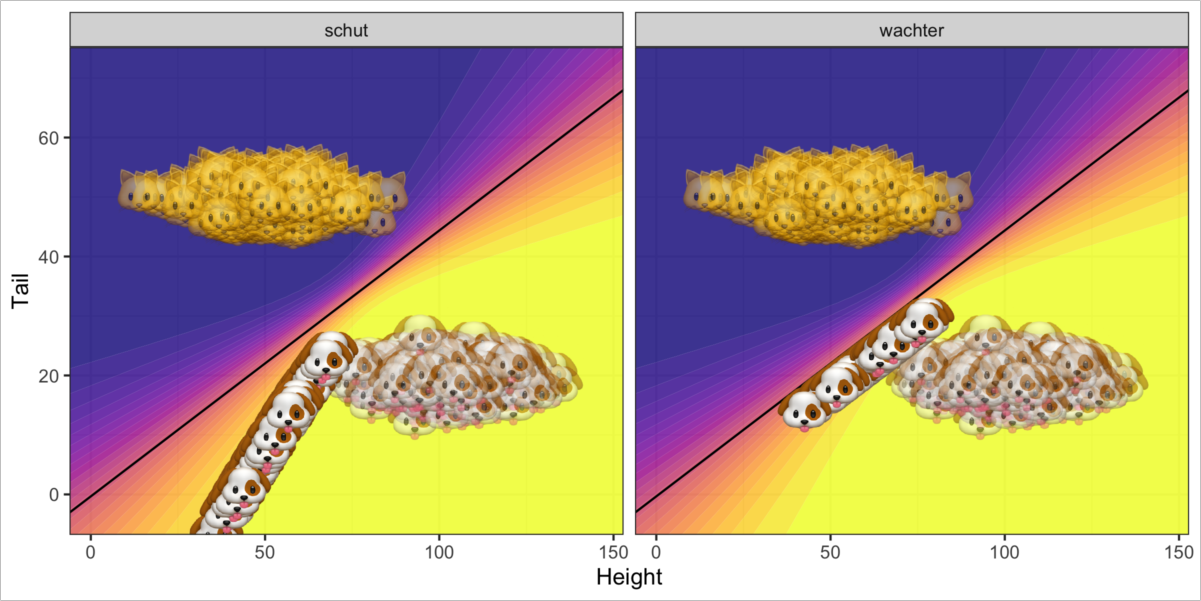

In [13]:
ggplot() + 
    geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(intercept=(1-w[1])/w[3], slope=-w[2]/w[3]) +
    geom_image(
        data=features[setdiff(1:size(features)[1],unhappy_cats),:], 
        aes(x=:x1, y=:x2, image=:emoji), 
        size=0.1, 
        image_fun=R"function(img) magick::image_fx(img, expression = '0.5*a', channel = 'alpha')"
    ) +
    geom_image(data=counterfactuals, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~type") +
    theme_bw() |>
    p -> ggsave("www/toy_endogenous_shifts.png", plot = p, width=8, height=4);
load("www/toy_endogenous_shifts.png")

### Retraining classifier

Finally, we will retrain the classifier (model shift) and plot the resulting new decision boundary and posterior predictive distribution.

In [14]:
estimates = DataFrame()
coefficients = DataFrame()
for j in 1:length(df_counterfactual)
    df_cf = df_counterfactual[j]
    recourse_name = String(keys(generators)[j])
    y = df_cf[:,:y];
    X = Matrix(df_cf[:,[:x1,:x2]]);
    model = bayes_logreg(X,y);
    coefficients_ = DataFrame(reshape(model.μ,(1,length(model.μ))), "w" .* string.(1:length(model.μ)))
    insertcols!(coefficients_, :const => 1-model.μ[1]/model.μ[3])
    insertcols!(coefficients_, :slope => -model.μ[2]/model.μ[3])
    insertcols!(coefficients_, :type => recourse_name)
    coefficients = vcat(coefficients,coefficients_);
    # Predictive posterior:
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    estimates_ = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(estimates_, :type => recourse_name)
    estimates = vcat(estimates, estimates_)
end

In [15]:
features = reduce(vcat, df_counterfactual);
transform!(features, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

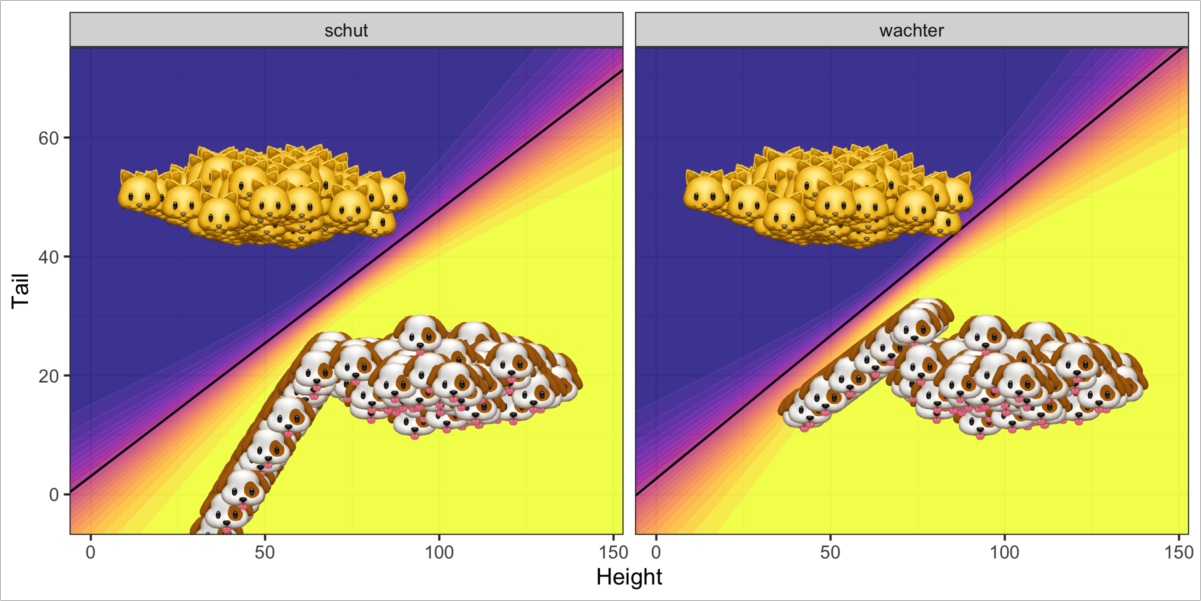

In [16]:
ggplot() + 
    geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(data=coefficients, aes(intercept=:const, slope=:slope)) +
    geom_image(data=features, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~type") +
    theme_bw() |>
    p -> ggsave("www/toy_post_shift.png", plot = p, width=8, height=4);
load("www/toy_post_shift.png")

### Single-period with holdout

The experimental setup in this section is adapted from Upadhyay et al. (2021):

1. Train classifier ($\mathcal{M}_1$) on 4 folds of data $\mathcal{D}$ (training data).
2. Provide and implement recourse to $\mu$% of the training data. 
3. Retrain the classifier ($\mathcal{M}_2$) on training data with counterfactual labels.
4. Provide recourse to 5th fold (holdout data).
5. Check validity of recourse provided in 2.

This procedure is repeated for $K$ folds.

In [17]:
include("../julia/experiments.jl");

In [18]:
target = 1
n_rounds = 10
run_experiment(X,y,bayes_logreg,target,generators,generator_args,experiment_holdout)

,validity,cost,period,fold,generator
,Float64,Float64,Int64,Int64,String
1,1.0,27.1895,1,1,wachter
2,1.0,28.4109,1,2,wachter
3,1.0,27.1505,1,3,wachter
4,1.0,27.8462,1,4,wachter
5,1.0,27.9982,1,5,wachter
6,1.0,33.5056,1,1,schut
7,1.0,33.7976,1,2,schut
8,1.0,33.4419,1,3,schut
9,1.0,34.1851,1,4,schut


## Dynamic

In [19]:
props = [0.01,0.05,0.1,0.25]
results = DataFrame()
for prop in props
    results_prop = run_experiment(X,y,bayes_logreg,target,generators,generator_args,experiment_dynamic)
    insertcols!(results_prop, :prop => prop)
    results = vcat(results, results_prop)
end

┌ Warning: RCall.jl: Saving 7 x 7 in image
└ @ RCall /Users/patrickaltmeyer/.julia/packages/RCall/iMDW2/src/io.jl:160


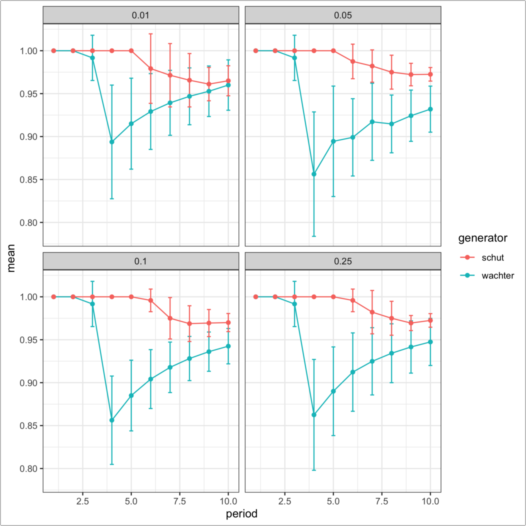

In [20]:
dt_plot = groupby(results, [:period, :generator, :prop]) |>
    gdf -> combine(gdf, :validity .=> [mean, std] .=> [:mean, :std])
dt_plot[!,:ymin] = dt_plot[!,:mean] - dt_plot[!,:std]
dt_plot[!,:ymax] = dt_plot[!,:mean] + dt_plot[!,:std]
ggplot(data=dt_plot, aes(x=:period, y=:mean, colour=:generator)) +
    geom_line() + 
    geom_errorbar(aes(ymin=:ymin, ymax=:ymax), width=.2) + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() |>
    p -> ggsave("www/toy_dynamic_validity.png", plot = p);
load("www/toy_dynamic_validity.png")

┌ Warning: RCall.jl: Saving 7 x 7 in image
└ @ RCall /Users/patrickaltmeyer/.julia/packages/RCall/iMDW2/src/io.jl:160


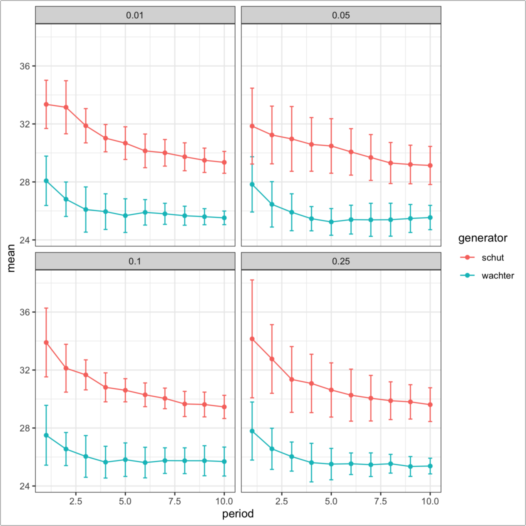

In [21]:
dt_plot = groupby(results, [:period, :generator, :prop]) |>
    gdf -> combine(gdf, :cost .=> [mean, std] .=> [:mean, :std])
dt_plot[!,:ymin] = dt_plot[!,:mean] - dt_plot[!,:std]
dt_plot[!,:ymax] = dt_plot[!,:mean] + dt_plot[!,:std]
ggplot(data=dt_plot, aes(x=:period, y=:mean, colour=:generator)) +
    geom_line() + 
    geom_errorbar(aes(ymin=:ymin, ymax=:ymax), width=.2) + 
    geom_point() +
    facet_wrap(R".~prop") +
    theme_bw() |>
    p -> ggsave("www/toy_dynamic_cost.png", plot = p);
load("www/toy_dynamic_cost.png")

#### Wachter et al.

In [22]:
y = df[:,:y];
X = Matrix(df[:,Not(:y)]);
evaluation, recourse_path, clf_path = experiment_dynamic(X,y,bayes_logreg,target,generators[1],generator_args[1]);

In [23]:
# Posterior predictive:
posterior_contour = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    posterior_contour_ = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(posterior_contour_, :period => i)
    posterior_contour = vcat(posterior_contour, posterior_contour_)
end

# Decision boundary:
decision_boundary = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    decision_boundary_ = DataFrame(intercept=(1-model.μ[1])/model.μ[3], slope=-model.μ[2]/model.μ[3], period=i)
    decision_boundary = vcat(decision_boundary, decision_boundary_)
end

# Emoji
transform!(recourse_path, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

In [24]:
ggplot() + 
    geom_contour_filled(data=posterior_contour, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(data=decision_boundary, aes(intercept=:intercept, slope=:slope)) +
    geom_image(data=recourse_path, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~period",ncol=round(n_rounds/2)) +
    theme_bw() |>
    p -> ggsave("www/dynamic_wachter.png", plot = p, width=8, height=2/(n_rounds/2)*8);

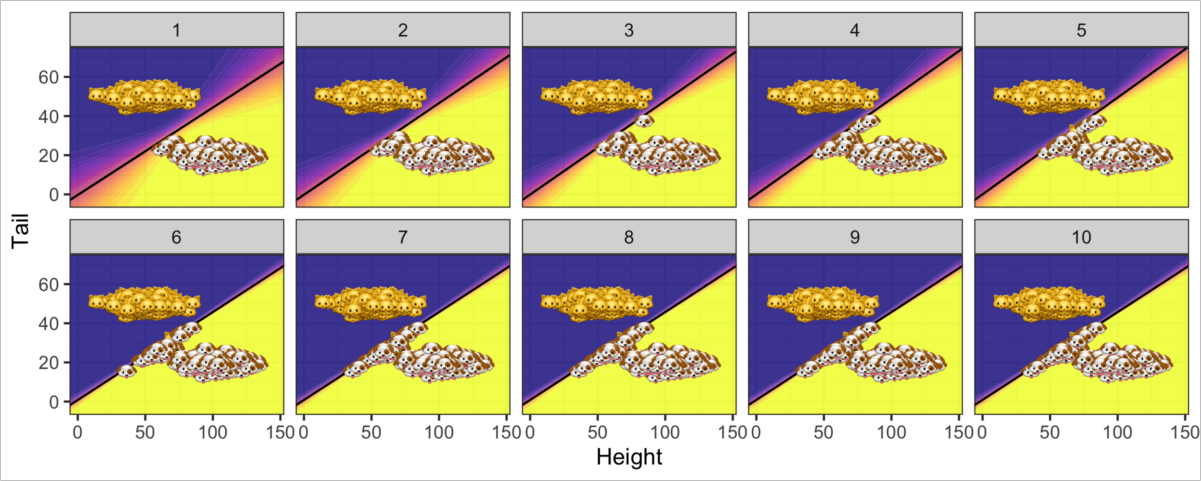

In [25]:
load("www/dynamic_wachter.png")

#### Schut et al.

In [26]:
y = df[:,:y];
X = Matrix(df[:,Not(:y)]);
evaluation, recourse_path, clf_path = experiment_dynamic(X,y,bayes_logreg,target,generators[2],generator_args[2]);

In [27]:
# Posterior predictive:
posterior_contour = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    posterior_contour_ = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(posterior_contour_, :period => i)
    posterior_contour = vcat(posterior_contour, posterior_contour_)
end

# Decision boundary:
decision_boundary = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    decision_boundary_ = DataFrame(intercept=(1-model.μ[1])/model.μ[3], slope=-model.μ[2]/model.μ[3], period=i)
    decision_boundary = vcat(decision_boundary, decision_boundary_)
end

# Emoji
transform!(recourse_path, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

In [28]:
ggplot() + 
    geom_contour_filled(data=posterior_contour, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(data=decision_boundary, aes(intercept=:intercept, slope=:slope)) +
    geom_image(data=recourse_path, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~period",ncol=round(n_rounds/2)) +
    theme_bw() |>
    p -> ggsave("www/dynamic_schut.png", plot = p, width=8, height=2/(n_rounds/2)*8);

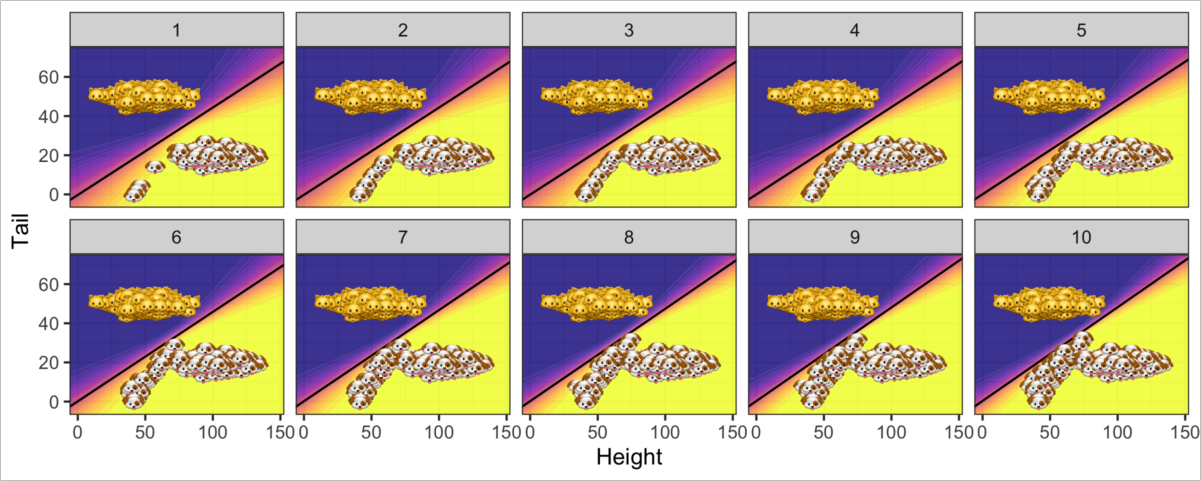

In [29]:
load("www/dynamic_schut.png")

## Bayesian Neural Network

Following the tutorial on Turing.jl: https://turing.ml/dev/tutorials/03-bayesian-neural-network/

In [30]:
include("../julia/bnn.jl")

LoadError: LoadError: Failed to precompile Flux [587475ba-b771-5e3f-ad9e-33799f191a9c] to /Users/patrickaltmeyer/.julia/compiled/v1.7/Flux/jl_FljHd6.
in expression starting at /Users/patrickaltmeyer/OneDrive - Delft University of Technology/git/recourse/julia/bnn.jl:3

In [31]:
# Number of points to generate.
N = 80
M = round(Int, N / 4)
Random.seed!(1234)

# Generate artificial data.
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt1s = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt1s, Array([[x1s[i] - 5; x2s[i] - 5] for i = 1:M]))

x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
xt0s = Array([[x1s[i] + 0.5; x2s[i] - 5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5; 
append!(xt0s, Array([[x1s[i] - 5; x2s[i] + 0.5] for i = 1:M]))

# Store all the data for later.
xs = [xt1s; xt0s]
ts = [ones(2*M); zeros(2*M)]

# Write to hard drive.
df = DataFrame(hcat(ts, transpose(hcat(xs...))), [:y, :x1, :x2])
CSV.write("../data/toy_nonlin.csv", df)

UndefVarError: UndefVarError: Random not defined

In [32]:
df = CSV.read("../data/toy_nonlin.csv", DataFrame);
p = ggplot(data=df, aes(x=:x1, y=:x2, colour=R"as.factor($df$y)")) +
    geom_point()
p

ERROR: LoadError: InitError: could not load symbol "LLVMExtraInitializeAllTargets":
dlsym(RTLD_DEFAULT, LLVMExtraInitializeAllTargets): symbol not found
Stacktrace:
  [1] LLVMInitializeAllTargets
    @ ~/.julia/packages/LLVM/srSVa/lib/libLLVM_extra.jl:10 [inlined]
  [2] InitializeAllTargets
    @ ~/.julia/packages/LLVM/srSVa/src/init.jl:58 [inlined]
  [3] __init__()
    @ GPUCompiler ~/.julia/packages/GPUCompiler/uTpNx/src/GPUCompiler.jl:46
  [4] _include_from_serialized(path::String, depmods::Vector{Any})
    @ Base ./loading.jl:768
  [5] _require_search_from_serialized(pkg::Base.PkgId, sourcepath::String)
    @ Base ./loading.jl:854
  [6] _require(pkg::Base.PkgId)
    @ Base ./loading.jl:1097
  [7] require(uuidkey::Base.PkgId)
    @ Base ./loading.jl:1013
  [8] require(into::Module, mod::Symbol)
    @ Base ./loading.jl:997
  [9] include
    @ ./Base.jl:418 [inlined]
 [10] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{Strin

RObject{VecSxp}


In [33]:
y = df[:,:y];
X = Matrix(df[:,Not(:y)]);

### Fit BNN

Prepare the model:

In [34]:
# Specify the network architecture.
network_shape = [
    (3,2, :tanh),
    (2,3, :tanh), 
    (1,2, :σ)
]

# Regularization, parameter variance, and total number of
# parameters.
alpha = 0.09
sig = sqrt(1.0 / alpha)
num_params = sum([i * o + i for (i, o, _) in network_shape])

bnn_instance = bnn(transpose(X), y, network_shape, num_params);

UndefVarError: UndefVarError: bnn not defined

Do inference through MC sampling (this step takes a moment):

In [35]:
chain = inference(bnn_instance);

UndefVarError: UndefVarError: inference not defined

In [36]:
step = 1;
expand = 1;
W = expandgrid((minimum(df.x1)-expand):step:(maximum(df.x1)+expand),(minimum(df.x2)-expand):step:(maximum(df.x2)+expand));
N_grid = size(W)[1];
y_probit = posterior_predictive(model, hcat(ones(N_grid), W));

nn_predict()

UndefVarError: UndefVarError: nn_predict not defined